## Visualising time-series

We visualise the time-series to get a better idea of the characteristics of our interlinkages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
import dcor
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation, DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
import numpy.polynomial.polynomial as poly
import warnings 
warnings.filterwarnings('ignore')

In [2]:
indicators_values_i = pickle.load(open('utils/data/indicators_values_i_up_wb.pkl', 'rb'))
targets_values_i = pickle.load(open('utils/data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('utils/data/goals_values_i_up_arr_wb.pkl', 'rb'))
dict_all = pickle.load(open('utils/data/dict_all_wb.pkl', 'rb'))
dict_all_std = pickle.load(open('utils/data/dict_all_wb_std.pkl', 'rb'))
dict_all_i = pickle.load(open('utils/data/dict_all_i_wb.pkl', 'rb'))
averages = pickle.load(open('distance_cor/goals/grouping_averages.pkl', 'rb'))
dict_t = pickle.load(open('utils/data/temp.pkl', 'rb'))

In [3]:
# read amended csv file
c = pd.read_csv('utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
continents = pd.read_csv(r'utils/continents.csv')
continents.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
groups = pd.read_csv(r'utils/groups.csv')
groups.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
info = pd.read_csv(r'utils/wb_info.csv', header=None)
period = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
info = info[info[0]!='DT.ODA.ODAT.CD']

In [4]:
# removes key in-place
countries.remove('Micronesia, Fed. Sts.')
continents['Oceania (excl. AUS + NZ)'] = continents['Oceania (excl. AUS + NZ)'].drop(index=4)
continents['Oceania (incl. AUS + NZ)'] = continents['Oceania (incl. AUS + NZ)'].drop(index=6)
continents['World'] = continents['World'].drop(index=170)
groups['Global South'].drop(index=1, inplace=True)

In [5]:
for country in countries:
    dict_t[country].set_index('YEAR', inplace=True)
    dict_t[country].index = dict_t[country].index.astype(str)
    dict_all_std[country] = dict_all_std[country].append(dict_t[country].AVG[-len(period):])
    dict_all_std[country].rename({'AVG': 'Temperature'}, inplace=True)
    dict_all[country] = dict_all[country].append(dict_t[country].AVG[-len(period):])
    dict_all[country].rename({'AVG': 'Temperature'}, inplace=True)

In [6]:
indicators = list(dict_all['France'].index)

In [7]:
targets = list(info[4].unique())

dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [8]:
#check 
dict_targets['7.1']

['EG.CFT.ACCS.ZS', 'EG.ELC.ACCS.RU.ZS', 'EG.ELC.ACCS.UR.ZS', 'EG.ELC.ACCS.ZS']

In [9]:
goals = list(info[3].unique())

dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

Defining combinations of goals:

In [10]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [11]:
g_combinations = list(combinations(goals, 2))
pairs_g1 = pd.DataFrame.from_records(data=g_combinations, columns=['pair_0', 'pair_1'])

In [12]:
# data preparation for continents (goals)
continents_prep_g = {}

for continent in continents:
    print(continent)
    
    continents_prep_g[continent] = np.empty(18, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in continents[continent].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        continents_prep_g[continent][g] = np.asarray(g_list)

Northern Africa
Eastern Africa
Middle Africa
Southern Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
North America
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Australia and New Zealand
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [43]:
# data preparation for continents (indicators)
continents_prep_i = {}

for continent in continents:
    print(continent)
    
    continents_prep_i[continent] = np.empty(len(dict_all['France']), dtype=object)
    
    for i, ind in enumerate(list(dict_all['France'].index)):
        i_list = []
        for country in continents[continent].dropna():
            i_list.append(np.asarray(dict_all[country].iloc[i].dropna()))

        continents_prep_i[continent][i] = np.asarray(i_list)

Northern Africa
Eastern Africa
Middle Africa
Southern Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
North America
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Australia and New Zealand
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [44]:
# data preparation for groups (goals)
groups_prep_g = {}

for group in groups:
    print(group)
    
    groups_prep_g[group] = np.empty(18, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in groups[group].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        groups_prep_g[group][g] = np.asarray(g_list)

Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


In [45]:
# data preparation for groups (indicators)
groups_prep_i = {}

for group in groups:
    print(group)
    
    groups_prep_i[group] = np.empty(len(dict_all['France']), dtype=object)
    
    for i, ind in enumerate(list(dict_all['France'].index)):
        i_list = []
        for country in groups[group].dropna():
            i_list.append(np.asarray(dict_all[country].iloc[i].dropna()))

        groups_prep_i[group][i] = np.asarray(i_list)

Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


In [46]:
# confidence intervals
def confidence(mean):
    interval = np.sqrt((mean * (100 - mean)) / 100)
    return interval

def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

### Visualising dependence between nodes without the influence of the conditional sets
To start with, we visualise the dependence between two indicators of the variables $X$ and $Y$ with standardised and imputed data we have available for them. We take the latest available measurements per country.
Our goal is to visualise the relationship between any two distance correlated nodes without the influence of the conditional set. We do so by regressing the conditional set $Z$ on both variables $X$ and $Y$ (with kernel ridge regression), and computing the residuals $r_x = x - f(z)$, and $r_y = y - f(z)$.
Then, we take the residuals of the latest measurements of the two indicators of the variables $X$ and $Y$ and plot these again.

In [47]:
# conditions
HI_cond = pd.read_csv('distance_cor/goals/conditions_High Income.csv', index_col=[0])
UMI_cond = pd.read_csv('distance_cor/goals/conditions_Upper middle Income.csv', index_col=[0])
LMI_cond = pd.read_csv('distance_cor/goals/conditions_Lower middle Income.csv', index_col=[0])
LI_cond = pd.read_csv('distance_cor/goals/conditions_Low Income.csv', index_col=[0])
LAC_cond = pd.read_csv('distance_cor/goals/conditions_Latin America and the Caribbean.csv', index_col=[0])
OPEC_cond = pd.read_csv('distance_cor/goals/conditions_OPEC.csv', index_col=[0])
SE_cond = pd.read_csv('distance_cor/goals/conditions_Southern Europe.csv', index_col=[0])
GS_cond = pd.read_csv('distance_cor/goals/conditions_Global South.csv', index_col=[0])
GN_cond = pd.read_csv('distance_cor/goals/conditions_Global North.csv', index_col=[0])

In [48]:
# example: SDG 8 and 17 in High Income
GS_8_17 = GS_cond.loc[(GS_cond['pair_0']=='8') & (GS_cond['pair_1']=='17')]
GS_8_17

,pair_0,pair_1,min_dcor,p-value,condition


## Comparison of dependence before and after regressed on conditional subset

### Example 1

In [ ]:
# before
ind_0 = 'NY.GDP.PCAP.PP.KD' 
ind_1 = 'SE.PRM.UNER.ZS' 
group = 'Latin America and the Caribbean'
last_n = 0

x = []
y = []
for country in continents[group].dropna():
#for country in groups[group].dropna():
    if len(dict_all_i[country].loc[ind_0].dropna())>last_n and len(dict_all_i[country].loc[ind_1].dropna())>last_n:
        x.extend(dict_all_i[country].loc[ind_0].dropna().tail(last_n+1).to_list())
        y.extend(dict_all_i[country].loc[ind_1].dropna().tail(last_n+1).to_list())

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    d_cor = dcor.distance_correlation(x, y)
    d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=10000)

    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.025)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'{}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'{}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(-0.85, -1.275, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_before.png', format='png')
    plt.show()

In [ ]:
# after
ind_0 = 'NY.GDP.PCAP.PP.KD'
pair_0 = int(info[info[0]==ind_0][3])
ind_1 = 'SE.PRM.UNER.ZS' 
pair_1 = int(info[info[0]==ind_1][3])
group = 'Latin America and the Caribbean'
last_n = 0

LAC_cond['pair_0'] = LAC_cond['pair_0'].astype(str)
if pair_0 > pair_1:
    group_cond = LAC_cond.loc[(LAC_cond['pair_0']=='{}'.format(pair_1)) & (LAC_cond['pair_1']=='{}'.format(pair_0))]
else:
    group_cond = LAC_cond.loc[(LAC_cond['pair_0']=='{}'.format(pair_0)) & (LAC_cond['pair_1']=='{}'.format(pair_1))]

if pair_0=='T':
    #x_res = groups_prep_g[group][17]
    x_res = continents_prep_g[group][17]
else:
    #x_res = groups_prep_g[group][int(pair_0)-1]
    x_res = continents_prep_g[group][int(pair_0)-1]
if pair_1=='T':
    #y_res = groups_prep_g[group][17]
    y_res = continents_prep_g[group][17]
else:
    #y_res = groups_prep_g[group][int(pair_1)-1]
    y_res = continents_prep_g[group][int(pair_1)-1]
    
# extracting conditional variables from column 'condition'
cond_list = []
for i in group_cond.condition.to_list()[0].split():
    newstr = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
    cond_list.extend([i for i in newstr.split()])

condition = []
for c in cond_list:
    if c=='T':
        #condition.extend(groups_prep_g[group][17].T)
        condition.extend(continents_prep_g[group][17].T)
    else:
        #condition.extend(groups_prep_g[group][int(c)-1].T)
        condition.extend(continents_prep_g[group][int(c)-1].T)

z = np.asarray(condition).T

krr_x = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_y = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_x.fit(z, x_res)
krr_y.fit(z, y_res)

# project z on x and y
z_proj_x_res = krr_x.predict(z)
z_proj_y_res = krr_y.predict(z)

# residuals
r_x = x_res - z_proj_x_res
r_y = y_res - z_proj_y_res

x = []
y = []
for c, country in enumerate(continents[group].dropna()):
#for country in groups[group].dropna():
    k_x = np.where(x_res[c]==indicators_values_i[country].loc[ind_0].tail(last_n+1)[0])[0]
    k_y = np.where(y_res[c]==indicators_values_i[country].loc[ind_1].tail(last_n+1)[0])[0]
    x.extend(r_x[c][k_x])
    y.extend(r_y[c][k_y])

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))
    
    # dcor with entire series
    pair_0_array = continents_prep_g[group][pair_0-1]
    pair_1_array = continents_prep_g[group][pair_1-1]
    d_cor = dcor.partial_distance_correlation(pair_0_array, pair_1_array, z)
    d_cor_test = dcor.independence.partial_distance_covariance_test(pair_0_array, pair_1_array, z, num_resamples=10000)

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.025)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(-1.35, 0.31, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_after.png', format='png')
    plt.show()

### Example 2

In [43]:
np.where(x_res[c]==indicators_values_i[country].loc[ind_0].dropna().tail(last_n+1)[0])[0]

NameError: name 'x_res' is not defined

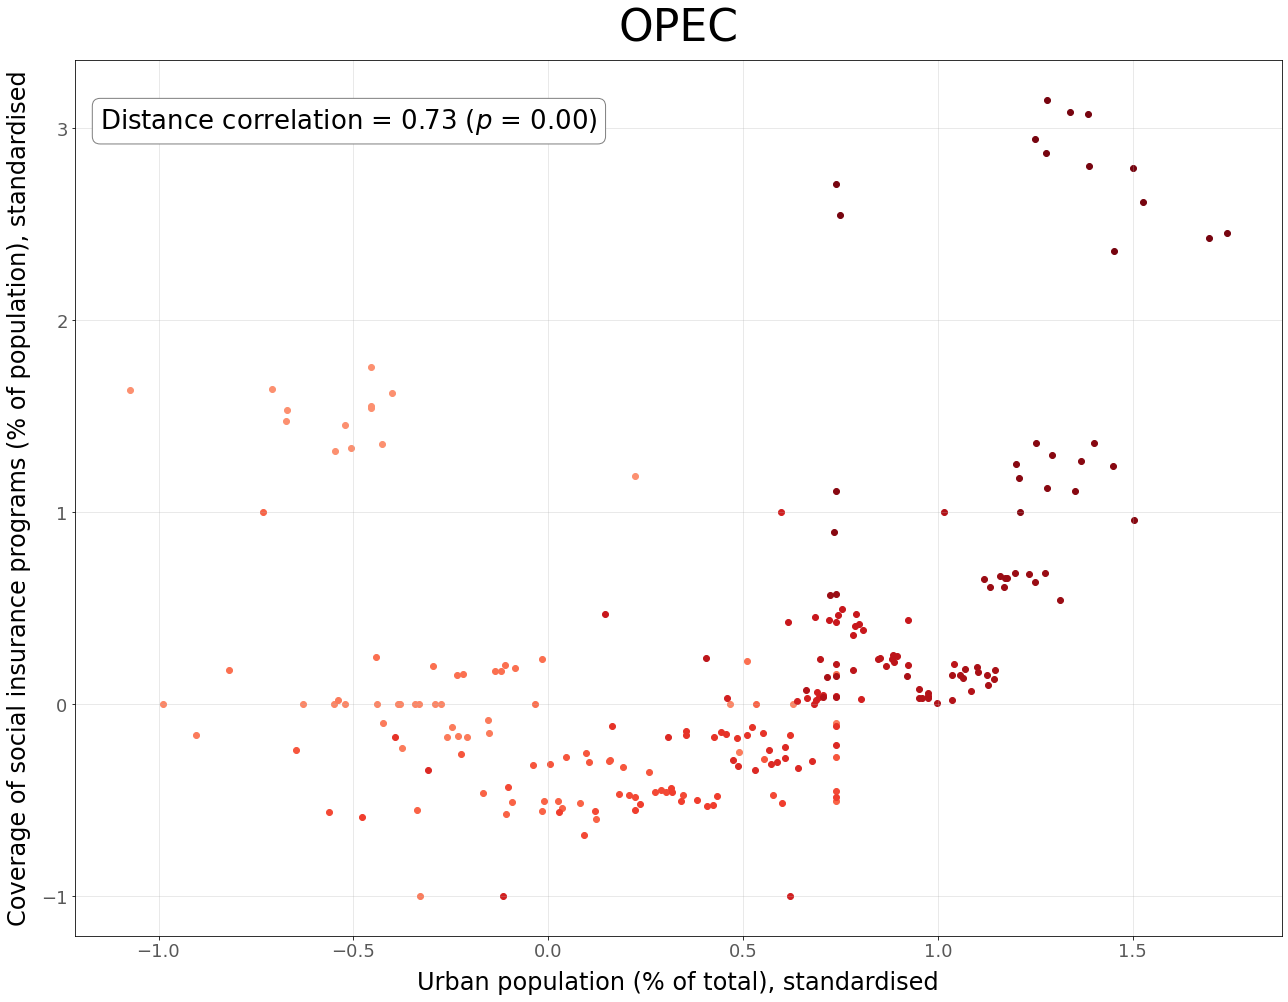

In [61]:
# before
ind_0 = 'SP.URB.TOTL.IN.ZS'
ind_1 = 'per_si_allsi.cov_pop_tot'
pair_0 = info[info[0]==ind_0][3].to_list()[0]
pair_1 = info[info[0]==ind_1][3].to_list()[0]
group = 'OPEC'
last_n = 0

x = []
y = []
#for country in continents[group].dropna():
for country in groups[group].dropna():
    if len(dict_all_i[country].loc[ind_0].dropna())>last_n and len(dict_all_i[country].loc[ind_1].dropna())>last_n:
        x.append(dict_all_i[country].loc[ind_0].dropna().to_list())
        y.append(dict_all_i[country].loc[ind_1].dropna().to_list())

x_arr = np.asarray(x)
y_arr = np.asarray(y)

d_cor = dcor.distance_correlation(x_arr, y_arr)
d_cor_test = dcor.independence.distance_covariance_test(x_arr, x_arr, num_resamples=10000)

# plot
plt.figure(figsize=(18,14))

dimensions = min(x_arr.shape[1], y_arr.shape[1])
for c, dim in enumerate(range(dimensions)):
    x_dim = x_arr[:, dim]
    y_dim = y_arr[:, dim]
    
    plt.scatter(x_dim, y_dim, color=sns.color_palette('Reds', dimensions+10)[c+10])

plt.xlabel(r'{}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
plt.ylabel(r'{}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
plt.xticks(size=18, alpha=0.65)
plt.yticks(size=18, alpha=0.65)
plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})

textstr = 'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value)
props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
plt.text(-1.15, 3, textstr, fontsize=26, bbox=props)

plt.grid(alpha=0.335)
plt.tight_layout()
#plt.savefig('distance_cor/conditioning_before_2.png', format='png')
plt.show()

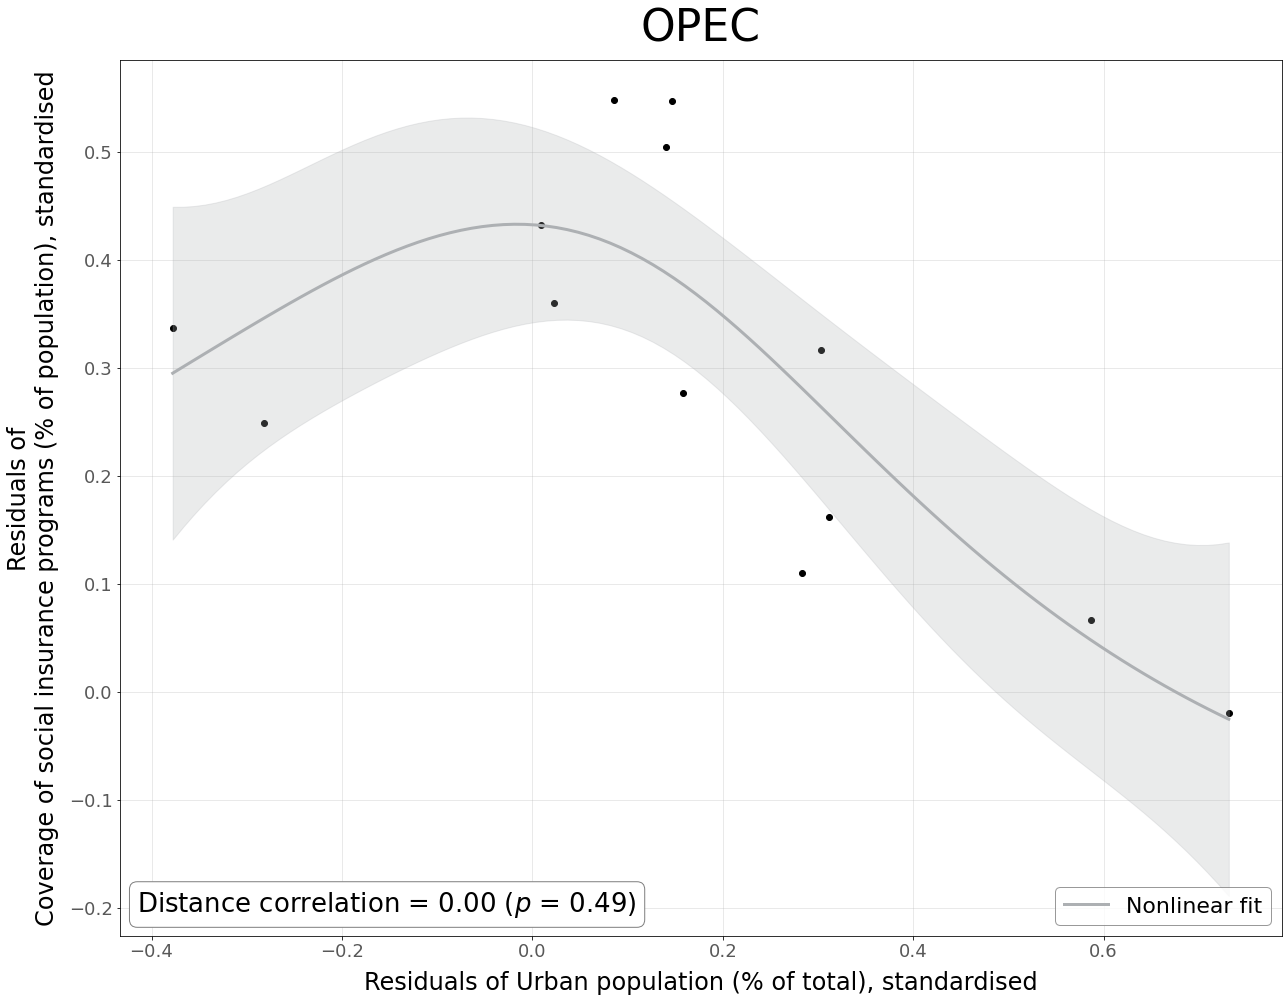

In [34]:
# after

OPEC_cond['pair_0'] = OPEC_cond['pair_0'].astype(str)
if pair_0 > pair_1:
    group_cond = OPEC_cond.loc[(OPEC_cond['pair_0']=='{}'.format(pair_1)) & (OPEC_cond['pair_1']=='{}'.format(pair_0))]
else:
    group_cond = OPEC_cond.loc[(OPEC_cond['pair_0']=='{}'.format(pair_0)) & (OPEC_cond['pair_1']=='{}'.format(pair_1))]

    
if pair_0=='T':
    x_res = groups_prep_g[group][17]
    #x_res = continents_prep_g[group][17]
else:
    x_res = groups_prep_g[group][int(pair_0)-1]
    #x_res = continents_prep_g[group][int(pair_0)-1]
if pair_1=='T':
    y_res = groups_prep_g[group][17]
    #y_res = continents_prep_g[group][17]
else:
    y_res = groups_prep_g[group][int(pair_1)-1]
    #y_res = continents_prep_g[group][int(pair_1)-1]

# extracting conditional variables from column 'condition'
cond_list = []
for i in group_cond.condition.to_list()[0].split():
    newstr = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
    cond_list.extend([i for i in newstr.split()])

condition = []
for c in cond_list:
    if c=='T':
        condition.extend(groups_prep_g[group][17].T)
        #condition.extend(continents_prep_g[group][17].T)
    else:
        condition.extend(groups_prep_g[group][int(c)-1].T)
        #condition.extend(continents_prep_g[group][int(c)-1].T)

z = np.asarray(condition).T

krr_x = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_y = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_x.fit(z, x_res)
krr_y.fit(z, y_res)

# project z on x and y
z_proj_x_res = krr_x.predict(z)
z_proj_y_res = krr_y.predict(z)

# residuals
r_x = x_res - z_proj_x_res
r_y = y_res - z_proj_y_res

x = []
y = []
#for c, country in enumerate(continents[group].dropna()):
for c, country in enumerate(groups[group].dropna()):
    k_x = np.where(x_res[c]==indicators_values_i[country].loc[ind_0].tail(last_n+1)[0])[0]
    k_y = np.where(y_res[c]==indicators_values_i[country].loc[ind_1].tail(last_n+1)[0])[0]
    if len(k_x) > 1:
        k_x = [k_x[-1]]
    if len(k_y) > 1:
        k_y = [k_y[-1]]
    x.extend(r_x[c][k_x])
    y.extend(r_y[c][k_y])

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))
    
    # dcor with entire series
    #pair_0_array = continents_prep_g[group][pair_0-1]
    #pair_1_array = continents_prep_g[group][pair_1-1]
    pair_0_array = groups_prep_g[group][pair_0-1]
    pair_1_array = groups_prep_g[group][pair_1-1]
    d_cor = dcor.partial_distance_correlation(pair_0_array, pair_1_array, z)
    d_cor_test = dcor.independence.partial_distance_covariance_test(pair_0_array, pair_1_array, z, num_resamples=10000)

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=1e-2)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    plt.fill_between(x_.flatten(), y_mean_gpr.flatten()-1.96*y_std_gpr, y_mean_gpr.flatten()+1.96*y_std_gpr, interpolate=True, alpha=0.25, color='#adb0b3')
    
    # fitting linear function to data
    #linreg = LinearRegression()
    #linreg.fit(x, y)
    #y_mean_linreg = linreg.predict(x_)
    #plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel('Residuals of\n{}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    textstr = 'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value)
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(-0.415, -0.2035, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_after_2.png', format='png')
    plt.show()

### Example 3

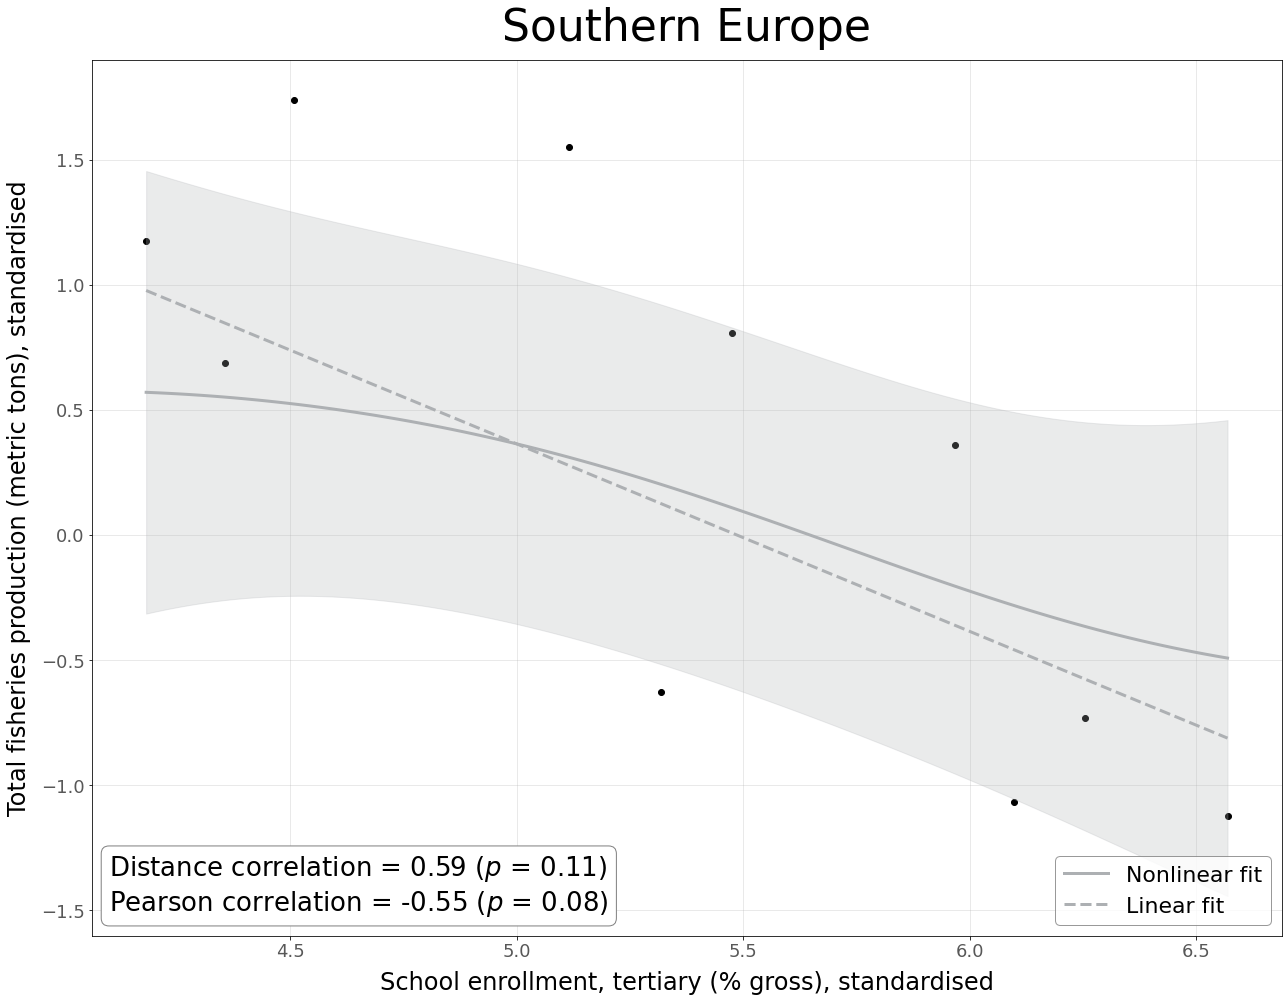

In [23]:
# before
ind_0 = 'SE.TER.ENRR'
ind_1 = 'ER.FSH.PROD.MT'
group = 'Southern Europe'
last_n = 0

x = []
y = []
for country in continents[group].dropna():
#for country in groups[group].dropna():
    if len(dict_all_i[country].loc[ind_0].dropna())>last_n and len(dict_all_i[country].loc[ind_1].dropna())>last_n:
        x.extend(dict_all_i[country].loc[ind_0].dropna().tail(last_n+1).to_list())
        y.extend(dict_all_i[country].loc[ind_1].dropna().tail(last_n+1).to_list())

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    d_cor = dcor.distance_correlation(x, y)
    d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=10000)

    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=1)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    plt.fill_between(x_.flatten(), y_mean_gpr.flatten()-1.96*y_std_gpr, y_mean_gpr.flatten()+1.96*y_std_gpr, interpolate=True, alpha=0.25, color='#adb0b3')
        
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'{}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'{}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(4.1, -1.5, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.335)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_before_3.png', format='png')
    plt.show()

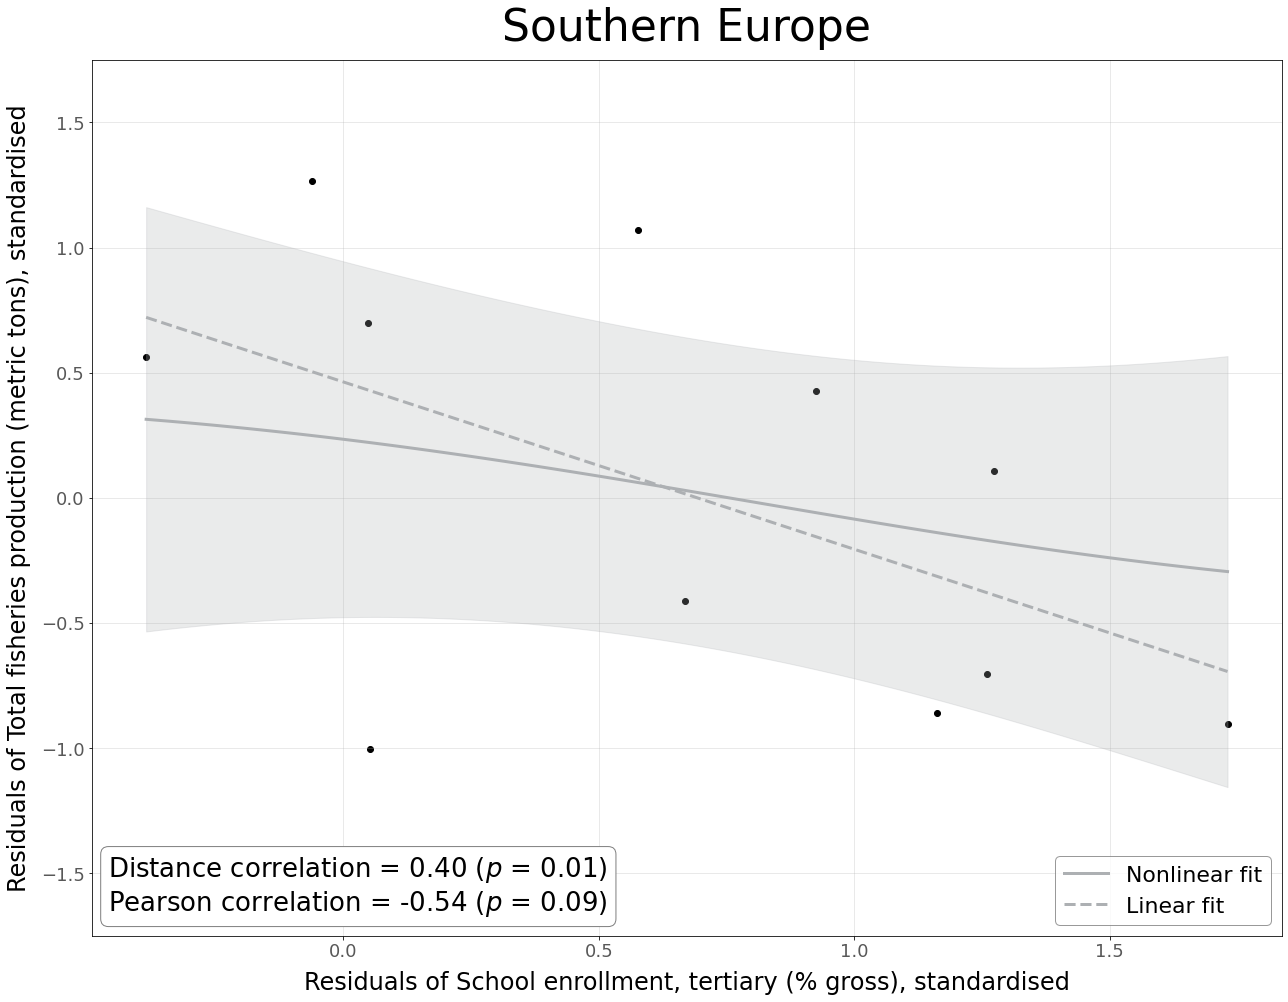

In [27]:
# after
pair_0 = int(info[info[0]==ind_0][3])
pair_1 = int(info[info[0]==ind_1][3])
last_n = 0

SE_cond['pair_0'] = SE_cond['pair_0'].astype(str)
group_cond = SE_cond.loc[(SE_cond['pair_0']=='{}'.format(pair_0)) & (SE_cond['pair_1']=='{}'.format(pair_1))]
   
if pair_0=='T':
    #x_res = groups_prep_g[group][17]
    x_res = continents_prep_g[group][17]
else:
    #x_res = groups_prep_g[group][int(pair_0)-1]
    x_res = continents_prep_g[group][int(pair_0)-1]
if pair_1=='T':
    pair_1 = 18
    #y_res = groups_prep_g[group][17]
    y_res = continents_prep_g[group][17]
else:
    #y_res = groups_prep_g[group][int(pair_1)-1]
    y_res = continents_prep_g[group][int(pair_1)-1]

# extracting conditional variables from column 'condition'
cond_list = []
for i in group_cond.condition.to_list()[0].split():
    newstr = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
    cond_list.extend([i for i in newstr.split()])

condition = []
for c in cond_list:
    if c=='T':
        #condition.extend(groups_prep_g[group][17].T)
        condition.extend(continents_prep_g[group][17].T)
    else:
        #condition.extend(groups_prep_g[group][int(c)-1].T)
        condition.extend(continents_prep_g[group][int(c)-1].T)

z = np.asarray(condition).T
krr_x = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_y = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_x.fit(z, x_res)
krr_y.fit(z, y_res)

# project z on x and y
z_proj_x_res = krr_x.predict(z)
z_proj_y_res = krr_y.predict(z)

# residuals
r_x = x_res - z_proj_x_res
r_y = y_res - z_proj_y_res

x = []
y = []
for c, country in enumerate(continents[group].dropna()):
#for c, country in enumerate(groups[group].dropna()):
    k_x = np.where(x_res[c]==indicators_values_i[country].loc[ind_0].dropna().tail(last_n+1)[0])[0]
    k_y = np.where(y_res[c]==indicators_values_i[country].loc[ind_1].dropna().tail(last_n+1)[0])[0]
    if len(k_x) > 1:
        k_x = [k_x[-1]]
    if len(k_y) > 1:
        k_y = [k_y[-1]]
    x.extend(r_x[c][k_x])
    y.extend(r_y[c][k_y])

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))
    
    # dcor with entire series
    pair_0_array = continents_prep_g[group][pair_0-1]
    pair_1_array = continents_prep_g[group][pair_1-1]
    #pair_0_array = groups_prep_g[group][pair_0-1]
    #pair_1_array = groups_prep_g[group][pair_1-1]
    d_cor = dcor.partial_distance_correlation(pair_0_array, pair_1_array, z)
    d_cor_test = dcor.independence.partial_distance_covariance_test(pair_0_array, pair_1_array, z, num_resamples=10000)

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=1)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    plt.fill_between(x_.flatten(), y_mean_gpr.flatten()-1.96*y_std_gpr, y_mean_gpr.flatten()+1.96*y_std_gpr, interpolate=True, alpha=0.25, color='#adb0b3')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel('Residuals of {}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.ylim((-1.75, 1.75))
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(-0.46, -1.65, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_after_3.png', format='png')
    plt.show()

## Comparing Global South and Global North
We plot the interlinkages particularly different in both groupings once the conditional sets are regressed out. 

In [315]:
info[info[3]=='10']

,0,1,2,3,4,5
287,DT.ODA.ODAT.CD1,Economic Policy & Debt: Official development a...,Net official development assistance received (...,10,10.b,1
288,DT.ODA.ODAT.KD,Economic Policy & Debt: Official development a...,Net official development assistance received (...,10,10.b,1
289,SI.DST.50MD,NaN,Proportion of people living below 50 percent o...,10,10.2,-1
290,SI.RMT.COST.IB.ZS,NaN,Average transaction cost of sending remittance...,10,10.c,-1
291,SI.RMT.COST.OB.ZS,NaN,Average transaction cost of sending remittance...,10,10.c,-1
292,SI.SPR.PC40.ZG,Poverty: Shared prosperity,Annualized average growth rate in per capita r...,10,10.1,1
293,SI.SPR.PCAP.ZG,Poverty: Shared prosperity,Annualized average growth rate in per capita r...,10,10.1,1


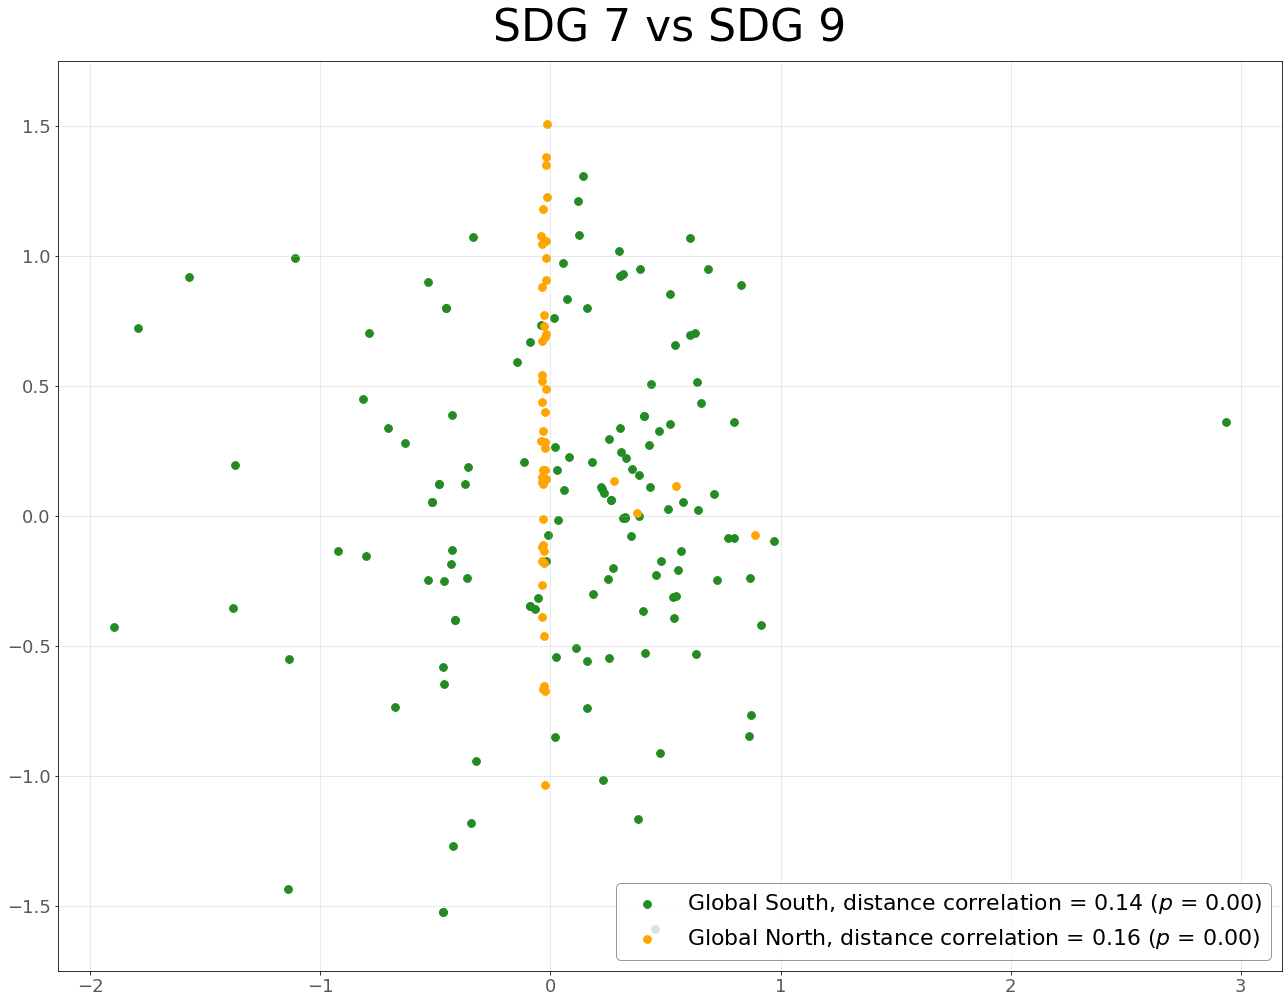

In [53]:
ind_1 = 'EN.ATM.CO2E.KD.GD'
ind_0 = 'EG.ELC.RNEW.ZS'
last_n = 0

pair_0 = int(info[info[0]==ind_0][3])
pair_1 = int(info[info[0]==ind_1][3])

GS_cond['pair_0'] = GS_cond['pair_0'].astype(str)
group_GS_cond = GS_cond.loc[(GS_cond['pair_0']=='{}'.format(pair_0)) & (GS_cond['pair_1']=='{}'.format(pair_1))]

GN_cond['pair_0'] = GN_cond['pair_0'].astype(str)
group_GN_cond = GN_cond.loc[(GN_cond['pair_0']=='{}'.format(pair_0)) & (GN_cond['pair_1']=='{}'.format(pair_1))]
   
if pair_0=='T':
    x_res_GS = groups_prep_g['Global South'][17]
    x_res_GN = groups_prep_g['Global North'][17]
    #x_res = continents_prep_g[group][17]
else:
    x_res_GS = groups_prep_g['Global South'][int(pair_0)-1]
    x_res_GN = groups_prep_g['Global North'][int(pair_0)-1]
    #x_res = continents_prep_g[group][int(pair_0)-1]
if pair_1=='T':
    pair_1 = 18
    y_res_GS = groups_prep_g['Global South'][17]
    y_res_GN = groups_prep_g['Global North'][17]
    #y_res = continents_prep_g[group][17]
else:
    y_res_GS = groups_prep_g['Global South'][int(pair_1)-1]
    y_res_GN = groups_prep_g['Global North'][int(pair_1)-1]
    #y_res = continents_prep_g[group][int(pair_1)-1]

# extracting conditional variables from column 'condition'
cond_list_GS = []
for i in group_GS_cond.condition.to_list()[0].split():
    newstr_GS = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
    cond_list_GS.extend([i for i in newstr_GS.split()])

condition_GS = []
for c in cond_list_GS:
    if c=='T':
        condition_GS.extend(groups_prep_g['Global South'][17].T)
        #condition.extend(continents_prep_g[group][17].T)
    else:
        condition_GS.extend(groups_prep_g['Global South'][int(c)-1].T)
        #condition.extend(continents_prep_g[group][int(c)-1].T)

cond_list_GN = []
for i in group_GN_cond.condition.to_list()[0].split():
    newstr_GN = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
    cond_list_GN.extend([i for i in newstr_GN.split()])

condition_GN = []
for c in cond_list_GN:
    if c=='T':
        condition_GN.extend(groups_prep_g['Global North'][17].T)
        #condition.extend(continents_prep_g[group][17].T)
    else:
        condition_GN.extend(groups_prep_g['Global North'][int(c)-1].T)
        #condition.extend(continents_prep_g[group][int(c)-1].T)

z_GS = np.asarray(condition_GS).T
krr_x_GS = KernelRidge(alpha=10, kernel='rbf', gamma=0.5/(width(z_GS)**2))
krr_y_GS = KernelRidge(alpha=10, kernel='rbf', gamma=0.5/(width(z_GS)**2))
krr_x_GS.fit(z_GS, x_res_GS)
krr_y_GS.fit(z_GS, y_res_GS)

z_GN = np.asarray(condition_GN).T
krr_x_GN = KernelRidge(alpha=10, kernel='rbf', gamma=0.5/(width(z_GN)**2))
krr_y_GN = KernelRidge(alpha=10, kernel='rbf', gamma=0.5/(width(z_GN)**2))
krr_x_GN.fit(z_GN, x_res_GN)
krr_y_GN.fit(z_GN, y_res_GN)

# project z on x and y
z_proj_x_res_GS = krr_x_GS.predict(z_GS)
z_proj_y_res_GS = krr_y_GS.predict(z_GS)

z_proj_x_res_GN = krr_x_GN.predict(z_GN)
z_proj_y_res_GN = krr_y_GN.predict(z_GN)

# residuals
r_x_GS = x_res_GS - z_proj_x_res_GS
r_y_GS = y_res_GS - z_proj_y_res_GS

r_x_GN = x_res_GN - z_proj_x_res_GN
r_y_GN = y_res_GN - z_proj_y_res_GN
 
# dcor with entire series
#pair_0_array = continents_prep_g[group][pair_0-1]
#pair_1_array = continents_prep_g[group][pair_1-1]
pair_0_array_GS = groups_prep_g['Global South'][pair_0-1]
pair_1_array_GS = groups_prep_g['Global South'][pair_1-1]
d_cor_GS = dcor.partial_distance_correlation(pair_0_array_GS, pair_1_array_GS, z_GS)
d_cor_test_GS = dcor.independence.partial_distance_covariance_test(pair_0_array_GS, pair_1_array_GS, z_GS, num_resamples=10000)

pair_0_array_GN = groups_prep_g['Global North'][pair_0-1]
pair_1_array_GN = groups_prep_g['Global North'][pair_1-1]
d_cor_GN = dcor.partial_distance_correlation(pair_0_array_GN, pair_1_array_GN, z_GN)
d_cor_test_GN = dcor.independence.partial_distance_covariance_test(pair_0_array_GN, pair_1_array_GN, z_GN, num_resamples=10000)

# plot x against y; each country is one data point
plt.figure(figsize=(18,14))

# finding indicator in pair_0_array again
len_pair_0 = 0
for ind in info[info[3]==str(pair_0)][0].tolist():
    l = len(indicators_values_i['Brazil'].loc[ind].dropna())
    len_pair_0 += l
    if ind==ind_0:
        plot_x_GS = r_x_GS[:, len_pair_0-l:len_pair_0]
        
len_pair_0 = 0
for ind in info[info[3]==str(pair_0)][0].tolist():
    l = len(indicators_values_i['France'].loc[ind].dropna())
    len_pair_0 += l
    if ind==ind_0:
        plot_x_GN = r_x_GN[:, len_pair_0-l:len_pair_0]

# finding indicator in pair_1_array again
len_pair_1 = 0
for ind in info[info[3]==str(pair_1)][0].tolist():
    l = len(indicators_values_i['Brazil'].loc[ind].dropna())
    len_pair_1 += l
    if ind==ind_1:
        plot_y_GS = r_y_GS[:, len_pair_1-l:len_pair_1]

len_pair_1 = 0
for ind in info[info[3]==str(pair_1)][0].tolist():
    l = len(indicators_values_i['France'].loc[ind].dropna())
    len_pair_1 += l
    if ind==ind_1:
        plot_y_GN = r_y_GN[:, len_pair_1-l:len_pair_1]
        
plt.scatter(plot_x_GS[:,-1], plot_y_GS[:,-1], c='forestgreen', s=60, label='Global South, distance correlation = %.2f ($p$ = %.2f)' % (d_cor_GS, d_cor_test_GS.p_value))
plt.scatter(plot_x_GN[:,-1], plot_y_GN[:,-1], c='orange', s=60, label='Global North, distance correlation = %.2f ($p$ = %.2f)' % (d_cor_GN, d_cor_test_GN.p_value))

# fitting non-linear function to data
#kernel = Matern(nu=2.5)
#kernel = RBF(length_scale=1)
#gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=1)
#gpr_x.fit(x, y)
#x_ = np.linspace(min(x), max(x), 100)
#y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)

#plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
#plt.fill_between(x_.flatten(), y_mean_gpr.flatten()-1.96*y_std_gpr, y_mean_gpr.flatten()+1.96*y_std_gpr, interpolate=True, alpha=0.25, color='#adb0b3')

#plt.xlabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_0][2].to_GSst()[0]), fontsize=24, labelpad=10)
#plt.ylabel('Residuals of {}, standardised'.format(info[info[0]==ind_1][2].to_GSst()[0]), fontsize=24, labelpad=10)
plt.xticks(size=18, alpha=0.65)
plt.yticks(size=18, alpha=0.65)
plt.ylim((-1.75, 1.75))
plt.title('SDG {} vs SDG {}'.format(pair_0, pair_1), y=1.015, fontdict={'fontsize': 44})

plt.grid(alpha=0.35)
plt.legend(loc=4, fontsize=22, edgecolor='grey')
plt.tight_layout()
#plt.savefig('distance_cor/conditioning_GSGN_1.png', format='png')
plt.show()

## Plotting the first principle components of the residuals of $X$ and $Y$

In [ ]:
def residuals_kpca(pair_0, pair_1, group):
    
    if group=='High Income':
        HI_cond['pair_0'] = HI_cond['pair_0'].astype(str)
        group_cond = HI_cond.loc[(HI_cond['pair_0']=='{}'.format(pair_0)) & (HI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Upper middle Income':
        UMI_cond['pair_0'] = UMI_cond['pair_0'].astype(str)
        group_cond = UMI_cond.loc[(UMI_cond['pair_0']=='{}'.format(pair_0)) & (UMI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Lower middle Income':
        LMI_cond['pair_0'] = LMI_cond['pair_0'].astype(str)
        group_cond = LMI_cond.loc[(LMI_cond['pair_0']=='{}'.format(pair_0)) & (LMI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Low Income':
        LI_cond['pair_0'] = LI_cond['pair_0'].astype(str)
        group_cond = LI_cond.loc[(LI_cond['pair_0']=='{}'.format(pair_0)) & (LI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Latin America and the Caribbean':
        LAC_cond['pair_0'] = LAC_cond['pair_0'].astype(str)
        group_cond = LAC_cond.loc[(LAC_cond['pair_0']=='{}'.format(pair_0)) & (LAC_cond['pair_1']=='{}'.format(pair_1))]
    else:
        raise ValueError('Not possible for this group yet.')
    
    if pair_0=='T':
        #x = groups_prep_g[group][17]
        x = continents_prep_g[group][17]
    else:
        #x = groups_prep_g[group][int(pair_0)-1]
        x = continents_prep_g[group][int(pair_0)-1]
        
    if pair_1=='T':
        #y = groups_prep_g[group][17]
        y = continents_prep_g[group][17]
    else:
        #y = groups_prep_g[group][int(pair_1)-1]
        y = continents_prep_g[group][int(pair_0)-1]
    
    # extracting conditional variables from column 'condition'
    cond_list = []
    for i in group_cond.condition.to_list()[0].split():
        newstr = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
        cond_list.extend([i for i in newstr.split()])

    condition = []
    for c in cond_list:
        if c=='T':
            #condition.extend(groups_prep_g[group][17].T)
            condition.extend(continents_prep_g[group][17].T)
        else:
            #condition.extend(groups_prep_g[group][int(c)-1].T)
            condition.extend(continents_prep_g[group][int(c)-1].T)

    z = np.asarray(condition).T

    krr_x = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
    krr_y = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
    krr_x.fit(z, x)
    krr_y.fit(z, y)
    z_proj_x = krr_x.predict(z)
    z_proj_y = krr_y.predict(z)

    # residuals
    r_x = x - z_proj_x
    r_y = y - z_proj_y 
    
    # selecting the principle component of r_y and r_x
    kpca_x = KernelPCA(n_components=1, kernel='rbf')
    kpca_y = KernelPCA(n_components=1, kernel='rbf')
    r_x_kpca = kpca_x.fit_transform(r_x)
    r_y_kpca = kpca_y.fit_transform(r_y)

    # plot r_x_kpca against r_y_kpca; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(r_x_kpca, r_y_kpca, c='k')

    kernel = Matern(nu=2.5)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-2).fit(r_x_kpca, r_y_kpca)
    x_ = np.linspace(min(r_x_kpca), max(r_x_kpca), 100)
    y_mean, y_std = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean, '#adb0b3', lw=3)
    plt.fill_between(x_.flatten(), y_mean.flatten()-1.96*y_std, y_mean.flatten()+1.96*y_std, interpolate=True, alpha=0.25, color='#adb0b3')
    x_label_x = 'SDG {}'.format(pair_0)
    if pair_1=='T':
        y_label_x = 'Mean Temperature'
    else:
        y_label_x = 'SDG {}'.format(pair_1)
    plt.xlabel(r'$1^{st}$ Principle Component of %s' % x_label_x, fontsize=32, labelpad=10)
    plt.ylabel(r'$1^{st}$ Principle Component of %s' % y_label_x, fontsize=32, labelpad=10)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    plt.show()
    
    return r_x_kpca, r_y_kpca

In [ ]:
# example
r_x_kpca, r_y_kpca = residuals_kpca(4, 17, 'Latin America and the Caribbean')

## Figure 1

In [ ]:
def corr(ind_0, ind_1, group, last_n=0):
    x = []
    y = []
    for country in continents[group].dropna():
    #for country in groups[group].dropna():
        if len(dict_all[country].loc[ind_0].dropna())>last_n and len(dict_all[country].loc[ind_1].dropna())>last_n:
            x.extend(dict_all[country].loc[ind_0].dropna().tail(last_n+1).to_list())
            y.extend(dict_all[country].loc[ind_1].dropna().tail(last_n+1).to_list())

    if len(x)<2 or len(y)<2:
        return None
    else:
        x = np.asarray(x).reshape(-1,1)
        y = np.asarray(y).reshape(-1,1)

        d_cor = dcor.distance_correlation(x, y)
        d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=5000)

        p_cor = pearsonr(x.reshape(-1), y.reshape(-1))
        
        return d_cor, d_cor_test.p_value, p_cor[0], p_cor[1]

In [ ]:
examples = {}

for group in ['Latin America and the Caribbean']:  #groups.columns.to_list():
    print('----------------------------------------')
    print(group)
    examples[group] = {}
    
    for ind_0 in indicators:
        for ind_1 in indicators:
            if ind_0!=ind_1:
                c = corr(ind_0, ind_1, group)
                if c==None:
                    pass
                elif 0.4<c[0]<1 and c[1]<0.05 and -0.15<c[2]<0.15 and c[3]>0.4:
                    examples[group][(ind_0, ind_1)] = c
                    print(group, ind_0, ind_1, c)
                else:
                    pass

In [ ]:
# save
exam = open('Figure_1_example_{}.pkl'.format(group), 'wb')
pickle.dump(examples[group], exam)
exam.close()

In [ ]:
# load
exam = pickle.load(open('Figure_1_example_Latin America and the Caribbean.pkl', 'rb'))

In [ ]:
ind_0 = 'NY.GDP.PCAP.PP.KD' 
ind_1 = 'SE.PRM.UNER.ZS' 
group = 'Latin America and the Caribbean'
last_n = 0

print(info[info[0]==ind_0][3])
print(info[info[0]==ind_1][3])

x = []
y = []
for country in continents[group].dropna():
#for country in groups[group].dropna():
    if len(dict_all[country].loc[ind_0].dropna())>last_n and len(dict_all[country].loc[ind_1].dropna())>last_n:
        x.extend(dict_all[country].loc[ind_0].dropna().tail(last_n+1).to_list())
        y.extend(dict_all[country].loc[ind_1].dropna().tail(last_n+1).to_list())

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    d_cor = dcor.distance_correlation(x, y)
    d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=10000)

    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.435)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    #plt.fill_between(x_.flatten(), y_mean_gpr.flatten()-19.6*y_std_gpr.flatten(), y_mean_gpr.flatten()+19.6*y_std_gpr.flatten(), interpolate=True, alpha=0.25, color='#adb0b3')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'{}'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'{}'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(20700, 40, textstr, fontsize=26, bbox=props)
    
    #x_arrow, y_arrow = 42, 53
    #plt.arrow(x_arrow, y_arrow, 1, 6, head_width=0.75, head_length=0.75, fc='#1b75bc', ec='#1b75bc', width=0.2)
    #plt.text(x_arrow-1, y_arrow-3, 'T', fontsize=28, c='#1b75bc', fontfamily='serif', fontweight='roman')
    
    x_arrow_c1, y_arrow_c1 = 3400, 41
    plt.arrow(x_arrow_c1, y_arrow_c1, -800, +0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c1+100, y_arrow_c1-0.5, 'Haiti', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c2, y_arrow_c2 = 34000, 24.5
    plt.arrow(x_arrow_c2, y_arrow_c2, 800, -0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c2-6250, y_arrow_c2-0.25, 'The Bahamas', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c3, y_arrow_c3 = 33000, 20
    plt.arrow(x_arrow_c3, y_arrow_c3, 800, 0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c3-5500, y_arrow_c3-0.5, 'Puerto Rico', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c4, y_arrow_c4 = 20000, 3.25
    plt.arrow(x_arrow_c4, y_arrow_c4, 1000, -2, head_width=0.65, head_length=350, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c4-2000, y_arrow_c4+0.5, 'Argentina', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c5, y_arrow_c5 = 30000, 12.25
    plt.arrow(x_arrow_c5, y_arrow_c5, 800, 0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c5-3600, y_arrow_c5-0.5, 'Panama', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/syn_tra_dependence_countries3.png', format='png')
    plt.show()

In [ ]:
# countries at threshold
for country in continents[group].dropna():
    if dict_all[country].loc[ind_0].isnull().all()==False and dict_all[country].loc[ind_1].isnull().all()==False:
        print(country, dict_all[country].loc[ind_0][dict_all[country].loc[ind_0].last_valid_index()], dict_all[country].loc[ind_1][dict_all[country].loc[ind_1].last_valid_index()])

## Table with most important variables

In [242]:
centr_continents = pickle.load(open('distance_cor/goals/centrality_continents.pkl', 'rb'))
centr_groups = pickle.load(open('distance_cor/goals/centrality_groups.pkl', 'rb'))

In [259]:
for key_c in centr_groups.keys():
    print(key_c, sorted(centr_groups[key_c], key=lambda i: i[1], reverse=True)[0:3])

Global North [(17, '0.53'), (9, '0.39'), (7, '0.36')]
Global South [(4, '0.41'), (17, '0.41'), (8, '0.31')]
Least Developed Countries (LDC) [(8, '0.48'), (4, '0.46'), (1, '0.43')]
Land Locked Developing Countries (LLDC) [(3, '0.53'), (18, '0.42'), (11, '0.38')]
Small Island Developing States (SIDS) [(8, '0.48'), (17, '0.42'), (4, '0.35')]
G20 [(7, '0.48'), (17, '0.40'), (2, '0.36')]
Emerging Markets (BRICS + N-11) [(16, '0.70'), (3, '0.52'), (6, '0.31')]
OPEC [(1, '0.52'), (17, '0.51'), (4, '0.44')]
Low Income [(17, '0.55'), (12, '0.40'), (9, '0.33')]
Lower middle Income [(11, '0.41'), (17, '0.38'), (18, '0.36')]
Upper middle Income [(18, '0.45'), (17, '0.41'), (8, '0.30')]
High Income [(17, '0.47'), (7, '0.43'), (9, '0.38')]


In [293]:
info[info[3]=='10']

,0,1,2,3,4,5
287,DT.ODA.ODAT.CD1,Economic Policy & Debt: Official development a...,Net official development assistance received (...,10,10.b,1
288,DT.ODA.ODAT.KD,Economic Policy & Debt: Official development a...,Net official development assistance received (...,10,10.b,1
289,SI.DST.50MD,NaN,Proportion of people living below 50 percent o...,10,10.2,-1
290,SI.RMT.COST.IB.ZS,NaN,Average transaction cost of sending remittance...,10,10.c,-1
291,SI.RMT.COST.OB.ZS,NaN,Average transaction cost of sending remittance...,10,10.c,-1
292,SI.SPR.PC40.ZG,Poverty: Shared prosperity,Annualized average growth rate in per capita r...,10,10.1,1
293,SI.SPR.PCAP.ZG,Poverty: Shared prosperity,Annualized average growth rate in per capita r...,10,10.1,1


In [267]:
dcor_goals_continents_2 = pickle.load(open('distance_cor/goals/dcor_goals_continents_2.pkl', 'rb'))
dcor_goals_groups_2 = pickle.load(open('distance_cor/goals/dcor_goals_groups_2.pkl', 'rb'))

In [278]:
print(np.sum(np.sum(np.abs(dcor_goals_continents_2['World'] - dcor_goals_groups_2['Global North']))))
print(np.sum(np.sum(np.abs(dcor_goals_continents_2['World'] - dcor_goals_groups_2['Global South']))))

4.898907218589794
4.03752213228252


In [283]:
dict_cor_goals_continents_2 = pickle.load(open('distance_cor/goals/dict_cor_goals_continents_2.pkl', 'rb'))
dict_cor_goals_groups_2 = pickle.load(open('distance_cor/goals/dict_cor_goals_groups_2.pkl', 'rb'))

In [289]:
sorted(np.sqrt(dict_cor_goals_groups_2['Global South'].min_dcor.tolist()), reverse=True)

[0.1813229812570119,
 0.1711438639542476,
 0.16889848064777907,
 0.160739457707022,
 0.15515321062868426,
 0.15368959916572933,
 0.14978660729884474,
 0.14553360261224285,
 0.14303945562481601,
 0.1413484170590402,
 0.13985364490329644,
 0.13692818599798365,
 0.11041741849224465,
 0.10436531763046128,
 0.10397162911790583,
 0.1001749329247068,
 0.09694037252584443,
 0.09173519535525886,
 0.09139031279508417,
 0.09025026075103519,
 0.0885237202139961,
 0.08656891025268365,
 0.0823328166267342,
 0.08225236410757923,
 0.07888623057979625,
 0.07862681912419113,
 0.07652586738669713,
 0.07612548798601537,
 0.07540379678275738,
 0.07456770700528677,
 0.0694797020526614,
 0.06613648235630556,
 0.06453850505362332,
 0.06397255833940145,
 0.06234428795293419,
 0.06171312507505523,
 0.06164755079368923,
 0.059694790811141464,
 0.058802289665791735,
 0.0581169009577068,
 0.05605605726741567,
 0.05570867491662532,
 0.0551174302667451,
 0.052805324535087496,
 0.05234557666901975,
 0.050769746921026

## Comparing Global South and Global North to World

In [12]:
# interlinkages
dict_cor_goals_continents_2 = pickle.load(open('distance_cor/goals/dict_cor_goals_continents_2.pkl', 'rb'))
dict_cor_goals_groups_2 = pickle.load(open('distance_cor/goals/dict_cor_goals_groups_2.pkl', 'rb'))

In [21]:
print(np.sum(np.abs(dict_cor_goals_groups_2['Global South'].min_dcor.to_numpy() - dict_cor_goals_continents_2['World'].min_dcor.to_numpy())))
print(np.sum(np.abs(dict_cor_goals_groups_2['Global North'].min_dcor.to_numpy() - dict_cor_goals_continents_2['World'].min_dcor.to_numpy())))

0.588030772922514
0.6274969004690404


In [11]:
# centrality
centr_goals_continents = pickle.load(open('distance_cor/goals/centrality_continents.pkl', 'rb'))
centr_goals_groups = pickle.load(open('distance_cor/goals/centrality_groups.pkl', 'rb'))

In [28]:
centr_goals_groups['Global South']

[(1, '0.27'),
 (2, '0.21'),
 (3, '0.25'),
 (4, '0.41'),
 (5, '0.13'),
 (6, '0.12'),
 (7, '0.25'),
 (8, '0.31'),
 (9, '0.21'),
 (10, '0.10'),
 (11, '0.24'),
 (12, '0.22'),
 (13, '0.14'),
 (14, '0.14'),
 (15, '0.06'),
 (16, '0.25'),
 (17, '0.41'),
 (18, '0.16')]

In [13]:
goals_GS = []
central_GS = []
for centr in centr_goals_groups['Global South']:
    goals_GS.append(centr[0])
    central_GS.append(float(centr[1]))
    
goals_GN = []
central_GN = []
for centr in centr_goals_groups['Global North']:
    goals_GN.append(centr[0])
    central_GN.append(float(centr[1]))
    
goals_W = []
central_W = []
for centr in centr_goals_continents['World']:
    goals_W.append(centr[0])
    central_W.append(float(centr[1]))

In [39]:
print(np.sum(np.abs(np.asarray(central_GS) - np.asarray(central_W))))
print(np.sum(np.abs(np.asarray(central_GN) - np.asarray(central_W))))

1.6200000000000003
1.2100000000000002


In [ ]:
DT.ODA.ALLD.CD

In [11]:
info[info[3]=='17']

,0,1,2,3,4,5
336,BX.KLT.DINV.CD.WD,Economic Policy & Debt: Balance of payments: C...,"Foreign direct investment, net inflows (BoP, c...",17,17.3,1
337,BX.KLT.DINV.WD.GD.ZS,Economic Policy & Debt: Balance of payments: C...,"Foreign direct investment, net inflows (% of GDP)",17,17.3,1
338,BX.TRF.PWKR.DT.GD.ZS,Economic Policy & Debt: Balance of payments: C...,"Personal remittances, received (% of GDP)",17,17.3,1
339,DT.ODA.ALLD.CD,Economic Policy & Debt: Official development a...,Net official development assistance and offici...,17,17.2,1
341,DT.TDS.DPPF.XP.ZS,Economic Policy & Debt: External debt: Debt ra...,"Debt service (PPG and IMF only, % of exports o...",17,17.4,1
342,GC.TAX.TOTL.CN,Public Sector: Government finance: Revenue,Tax revenue (current LCU),17,17.1,1
343,GC.TAX.TOTL.GD.ZS,Public Sector: Government finance: Revenue,Tax revenue (% of GDP),17,17.1,1
344,IE.PPI.ENGY.CD,Private Sector & Trade: Private infrastructure...,Investment in energy with private participatio...,17,17.17,1
345,IE.PPI.TRAN.CD,Private Sector & Trade: Private infrastructure...,Investment in transport with private participa...,17,17.17,1
346,IE.PPI.WATR.CD,Private Sector & Trade: Private infrastructure...,Investment in water and sanitation with privat...,17,17.17,1


In [25]:
dict_all['Kenya'].loc['DT.ODA.ALLD.CD']

TimePeriod
1990    1.181290e+09
1991    9.164600e+08
1992    8.849200e+08
1993    9.156300e+08
1994    6.778700e+08
1995    7.330900e+08
1996    5.962600e+08
1997    4.486500e+08
1998    4.152600e+08
1999    3.112500e+08
2000    5.139200e+08
2001    4.724100e+08
2002    3.882200e+08
2003    5.229000e+08
2004    6.559300e+08
2005    7.565700e+08
2006    9.416500e+08
2007    1.329360e+09
2008    1.363400e+09
2009    1.782480e+09
2010    1.631260e+09
2011    2.478820e+09
2012    2.653660e+09
2013    3.306840e+09
2014    2.661030e+09
2015    2.463520e+09
2016    2.188390e+09
2017    2.480220e+09
2018    2.488390e+09
2019             NaN
Name: DT.ODA.ALLD.CD, dtype: float64

## Pearson, Spearman and distance correlations

In [13]:
from scipy.stats import pearsonr, spearmanr

In [14]:
noise = 0.1

A = np.random.uniform(-1,1,128).reshape(-1,1)
B = A**2 + np.random.uniform(-noise,noise,128).reshape(-1,1)
C = A**3 + np.random.uniform(-noise,noise,128).reshape(-1,1)
D = A**4 + np.random.uniform(-noise,noise,128).reshape(-1,1)
E = A + np.random.uniform(-noise,noise,128).reshape(-1,1)

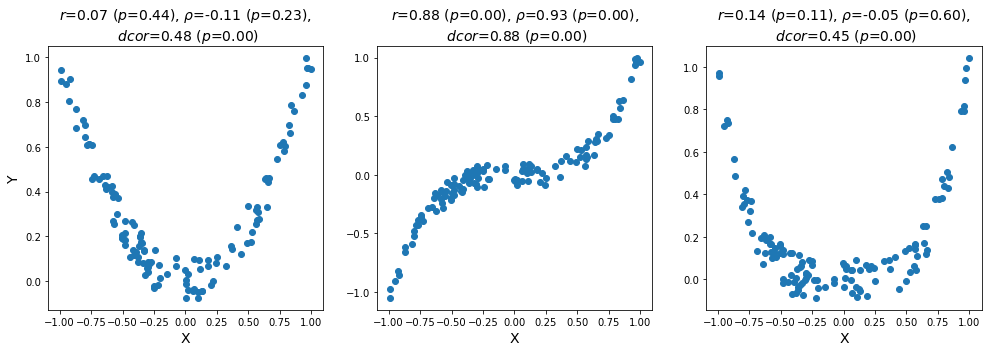

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))

ax1.set_title(r'$r$={:.2f} ($p$={:.2f}), $\rho$={:.2f} ($p$={:.2f}),'.format(pearsonr(A.reshape(-1),B.reshape(-1))[0], pearsonr(A.reshape(-1),B.reshape(-1))[1], spearmanr(A.reshape(-1),B.reshape(-1))[0], spearmanr(A.reshape(-1),B.reshape(-1))[1]) + '\n $dcor$={:.2f} ($p$={:.2f})'.format(dcor.distance_correlation(A,B), dcor.independence.distance_covariance_test(A,B, num_resamples=10000).p_value), fontsize=14)
ax1.set_xlabel('X', fontsize=14)
ax1.set_ylabel('Y', fontsize=14)
ax1.scatter(A, B);

ax2.set_title(r'$r$={:.2f} ($p$={:.2f}), $\rho$={:.2f} ($p$={:.2f}),'.format(pearsonr(A.reshape(-1),C.reshape(-1))[0], pearsonr(A.reshape(-1),C.reshape(-1))[1], spearmanr(A.reshape(-1),C.reshape(-1))[0], spearmanr(A.reshape(-1),C.reshape(-1))[1]) + '\n $dcor$={:.2f} ($p$={:.2f})'.format(dcor.distance_correlation(A,C), dcor.independence.distance_covariance_test(A,C, num_resamples=10000).p_value), fontsize=14)
ax2.set_xlabel('X', fontsize=14)
ax2.scatter(A, C);

ax3.set_title(r'$r$={:.2f} ($p$={:.2f}), $\rho$={:.2f} ($p$={:.2f}),'.format(pearsonr(A.reshape(-1),D.reshape(-1))[0], pearsonr(A.reshape(-1),D.reshape(-1))[1], spearmanr(A.reshape(-1),D.reshape(-1))[0], spearmanr(A.reshape(-1),D.reshape(-1))[1]) + '\n $dcor$={:.2f} ($p$={:.2f})'.format(dcor.distance_correlation(A,D), dcor.independence.distance_covariance_test(A,D, num_resamples=10000).p_value), fontsize=14)
ax3.set_xlabel('X', fontsize=14)
ax3.scatter(A, D);

plt.tight_layout()
plt.savefig('r_dcor.png')

In [41]:
print(r'$r$={:.2f} ($p$={:.2f}), $\rho$={:.2f} ($p$={:.2f}),'.format(pearsonr(A.reshape(-1),E.reshape(-1))[0], pearsonr(A.reshape(-1),E.reshape(-1))[1], spearmanr(A.reshape(-1),E.reshape(-1))[0], spearmanr(A.reshape(-1),E.reshape(-1))[1]) + '\n $dcor$={:.2f} ($p$={:.2f})'.format(dcor.distance_correlation(A,E), dcor.independence.distance_covariance_test(A,E, num_resamples=10000).p_value))


$r$=0.99 ($p$=0.00), $\rho$=0.99 ($p$=0.00),
 $dcor$=0.99 ($p$=0.00)


### Differences between selected groupings

We compute how different opposing socio-economic groupings are. We choose **Global South vs Global North** and **Low Income vs High Income** as the groupings of interest.

In [ ]:
cor_goals_groups_2['Global South'].to_csv('distance_cor/GS.csv')
cor_goals_groups_2['Global North'].to_csv('distance_cor/GN.csv')
cor_goals_groups_2['Low Income'].to_csv('distance_cor/LI.csv')
cor_goals_groups_2['Lower middle Income'].to_csv('distance_cor/LMI.csv')
cor_goals_groups_2['Upper middle Income'].to_csv('distance_cor/UMI.csv')
cor_goals_groups_2['High Income'].to_csv('distance_cor/HI.csv')

In [ ]:
GS_GN = cor_goals_groups_2['Global South'] - cor_goals_groups_2['Global North']
LI_HI = cor_goals_groups_2['Low Income'] - cor_goals_groups_2['High Income']
LI_LMI = cor_goals_groups_2['Low Income'] - cor_goals_groups_2['Lower middle Income']
LI_UMI = cor_goals_groups_2['Low Income'] - cor_goals_groups_2['Upper middle Income']
LMI_UMI = cor_goals_groups_2['Lower middle Income'] - cor_goals_groups_2['Upper middle Income']
UMI_HI = cor_goals_groups_2['Upper middle Income'] - cor_goals_groups_2['High Income']

# saving files
GS_GN.to_csv('distance_cor/GS_GN.csv')
LI_HI.to_csv('distance_cor/LI_HI.csv')
LI_LMI.to_csv('distance_cor/LI_LMI.csv')
LI_UMI.to_csv('distance_cor/LI_UMI.csv')
LMI_UMI.to_csv('distance_cor/LMI_UMI.csv')
UMI_HI.to_csv('distance_cor/UMI_HI.csv')

### Which countries are closest to the average in each grouping?
We want to find one country in each grouping that represents the grouping most accurately. To do so, we compute the average of each indicator over all countries in each grouping first, and calculate then the distance between each country in this grouping to these averages of the indicators. 

The distance between country $C$ and the average of the grouping $A$ can be defined as
$$
d(C, A) = \sqrt{\sum_{i=1}^n \sum_{t=1}^T (C_{it} - A_{it})^2},
$$
where $n$ is the number of indicators in this grouping, and $T$ the years. Here, the inner sum $\sum_{t=1}^T (C_{it} - A_{it})^2$ computes the squared Euclidean distance between any given indicator, before all $n$ indicators are summed up and sqaure-rooted.

In [ ]:
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [ ]:
averages = {}
for group in ['Global North', 'Global South', 'Low Income', 'Lower middle Income', 'Upper middle Income', 'High Income']:
    print(group)
    #averages[group] = pd.DataFrame(index=indicators_values_i['Germany'].index, columns=years)
    averages[group] = pd.DataFrame(index=dict_all_std['Germany'].index, columns=years)
    
    for indicator in averages[group].index:
        for year in years:
            year_list = []
            for country in groups[group].dropna():
                #year_list.append(indicators_values_i[country].loc[indicator, year])
                year_list.append(dict_all_std[country].loc[indicator, year])
            averages[group].loc[indicator, year] = np.nanmean(year_list)

In [ ]:
# saving averages
group_avg = open('distance_cor/goals/grouping_averages.pkl', 'wb')
pickle.dump(averages, group_avg)
group_avg.close()

In [ ]:
# distance from each country in a grouping to the average of this grouping
distances = {}    
for group in ['Global North', 'Global South', 'Low Income', 'Lower middle Income', 'Upper middle Income', 'High Income']:
    print(group)
    distances[group] = {}
    
    for country in groups[group].dropna():
        e_list = []
        #for indicator in indicators_values_i[country].index:
        for indicator in dict_all_std[country].index:
            country_e = []
            averages_e = []
            j = 0    # counter

            for year in years:
                # we can only consider years with data available in both countries
                #if pd.isna(indicators_values_i[country].loc[indicator, year]) is False and pd.isna(averages[group].loc[indicator, year]) is False:
                if pd.isna(dict_all_std[country].loc[indicator, year]) is False and pd.isna(averages[group].loc[indicator, year]) is False:
                    #country_e.append(indicators_values_i[country].loc[indicator, year])
                    country_e.append(dict_all_std[country].loc[indicator, year])
                    averages_e.append(averages[group].loc[indicator, year])

                    j += 1

            # distance between country and grouping average per indicator
            if j > 0:
                e_list.append(distance.sqeuclidean(country_e, averages_e, w=1/j))
            else:
                e_list.append(np.nan)    # make NaN

        distances[group][country] = np.sqrt(np.nansum(e_list))

In [ ]:
country_reps = {}
for group in ['Global North', 'Global South', 'Low Income', 'Lower middle Income', 'Upper middle Income', 'High Income']:
    country_reps[group] = min(distances[group], key=distances[group].get)

In [ ]:
sorted_distances = {}
for group in ['Global North', 'Global South', 'Low Income', 'Lower middle Income', 'Upper middle Income', 'High Income']:
    sorted_distances[group] = sorted(distances[group].items(), key=lambda x: x[1], reverse=False)
    pd.DataFrame(sorted_distances[group]).to_csv('distance_cor/distances_average_{}.csv'.format(group))

In [ ]:
for group in ['Global North', 'Global South', 'Low Income', 'Lower middle Income', 'Upper middle Income', 'High Income']:
    print(group)
    print('1st closest:', sorted_distances[group][0][1]/1000, sorted_distances[group][0][0])
    print('2nd closest:', sorted_distances[group][1][1]/1000, sorted_distances[group][1][0])
    print('3rd closest:', sorted_distances[group][2][1]/1000, sorted_distances[group][2][0])
    print('4th closest:', sorted_distances[group][3][1]/1000, sorted_distances[group][3][0])
    print('5th closest:', sorted_distances[group][4][1]/1000, sorted_distances[group][4][0])
    print('--------------------------')